In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
cd zr-obp/


/home/foundry/jupyter/shion.ishikawa/workspace/research/zr-obp


In [3]:
from tqdm import tqdm

from obp.ope.estimators import InverseProbabilityWeighting
from obp.policy.linear import LinTS
from obp.policy.contextfree import BernoulliTS, Random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss
from obp.dataset import SyntheticBanditDataset
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.linear_model import LogisticRegression

# import open bandit pipeline (obp)
import obp
from obp.dataset import (
    SyntheticBanditDataset,
    logistic_reward_function,
    linear_reward_function
)
from obp.policy import IPWLearner, Random
# ALEXPは、linearなsubpolicyしか使えないので検証に使わないかも
from obp.policy.model_selection import ModelSelectionPolicy, MetaExp3P, MetaCORRAL, MetaEXPOPE
from obp.ope import (
    OffPolicyEvaluation, 
    RegressionModel,
    InverseProbabilityWeighting,
    DirectMethod,
    DoublyRobust
)
import pandas as pd
from obp.simulator.simulator import BanditEnvironmentSimulator
from tqdm import tqdm
import seaborn as sns
sns.set()


In [4]:
# config
n_rounds = 100
num_batch = 200
T = n_rounds * num_batch
n_actions = 5
dim_context = 5
n_random_seed = 5
#lambdas = [0, 2.5, 5, 7.5, 10]

lambdas = [0, 0.25, 0.5, 2.5, 5]

# MetaExp3P

In [5]:
result_dic = {}

In [6]:
from tqdm import tqdm
# simulation. Environment is provided 
np.random.seed(0)
results = []
regrets = []
for lam in lambdas:
    print('lambda:', lam)
    for seed in range(n_random_seed):
        lints = LinTS(dim=dim_context, n_actions=n_actions)
        ts = BernoulliTS(n_actions=n_actions)
        be = BanditEnvironmentSimulator(n_actions=n_actions, dim_context=dim_context, reward_function=logistic_reward_function)
        policy = MetaExp3P(dim=5, policies=[lints, ts], n_actions=n_actions)
        regret = []
        for i in tqdm(range(num_batch)):
            # observe contexts
            contexts = be.next_context_batch(n_rounds=n_rounds)
            actions = []
            for context in contexts:
                actions.append(policy.select_action(context))
            expected = be.calc_expected_reward(contexts * lam)
            best_actions = pd.DataFrame(expected).idxmax(axis=1)
            regret.append((pd.Series(best_actions) != pd.Series(actions)).tolist())
            # observe rewards
            # adjust impact of contetual effect for reward function
            rewards = be.sample_reward(contexts * lam)
            policy.update_params(action=np.array(actions), reward=rewards[np.arange(len(rewards)), actions], context=contexts)
        
        result = [lam]
        for policy_index in range(2):
            result.append((pd.Series(policy.selected_policies) == policy_index).sum())
        print(result, np.array(regret).flatten().sum())
        regrets.append(regret)
        results.append(result)


lambda: 0


100%|██████████| 200/200 [00:03<00:00, 52.60it/s]


[0, 4902, 15098] 3437


100%|██████████| 200/200 [00:06<00:00, 32.52it/s]


[0, 10504, 9496] 7088


100%|██████████| 200/200 [00:02<00:00, 75.85it/s]


[0, 2068, 17932] 1648


100%|██████████| 200/200 [00:02<00:00, 90.09it/s]


[0, 1023, 18977] 944


100%|██████████| 200/200 [00:04<00:00, 47.10it/s]


[0, 6008, 13992] 4185
lambda: 0.25


100%|██████████| 200/200 [00:04<00:00, 41.70it/s]


[0.25, 6952, 13048] 5513


100%|██████████| 200/200 [00:04<00:00, 46.06it/s]


[0.25, 5920, 14080] 5240


100%|██████████| 200/200 [00:03<00:00, 54.76it/s]


[0.25, 4339, 15661] 4328


100%|██████████| 200/200 [00:04<00:00, 45.30it/s]


[0.25, 6127, 13873] 5080


100%|██████████| 200/200 [00:03<00:00, 60.64it/s]


[0.25, 3498, 16502] 3586
lambda: 0.5


100%|██████████| 200/200 [00:03<00:00, 66.46it/s]


[0.5, 2857, 17143] 6332


100%|██████████| 200/200 [00:05<00:00, 39.52it/s]


[0.5, 7813, 12187] 8458


100%|██████████| 200/200 [00:04<00:00, 46.21it/s]


[0.5, 6120, 13880] 7816


100%|██████████| 200/200 [00:04<00:00, 42.70it/s]


[0.5, 6896, 13104] 8352


100%|██████████| 200/200 [00:05<00:00, 36.56it/s]


[0.5, 8804, 11196] 8758
lambda: 2.5


100%|██████████| 200/200 [00:07<00:00, 27.82it/s]


[2.5, 12951, 7049] 9666


100%|██████████| 200/200 [00:05<00:00, 36.81it/s]


[2.5, 8705, 11295] 11198


100%|██████████| 200/200 [00:06<00:00, 31.11it/s]


[2.5, 11162, 8838] 11419


100%|██████████| 200/200 [00:05<00:00, 34.51it/s]


[2.5, 9510, 10490] 10723


100%|██████████| 200/200 [00:09<00:00, 20.98it/s]


[2.5, 18525, 1475] 8991
lambda: 5


100%|██████████| 200/200 [00:09<00:00, 22.08it/s]


[5, 17448, 2552] 7231


100%|██████████| 200/200 [00:07<00:00, 26.32it/s]


[5, 13872, 6128] 9423


100%|██████████| 200/200 [00:06<00:00, 31.62it/s]


[5, 10725, 9275] 10934


100%|██████████| 200/200 [00:08<00:00, 23.34it/s]


[5, 16136, 3864] 8657


100%|██████████| 200/200 [00:08<00:00, 22.98it/s]

[5, 16425, 3575] 8367


In [7]:
pd.DataFrame(results).to_csv('../metaexp3p_selection.csv')
pd.DataFrame(regrets).to_csv('../metaexp3p_regret.csv')

Text(0.5, 1.0, 'MetaEXP3P')

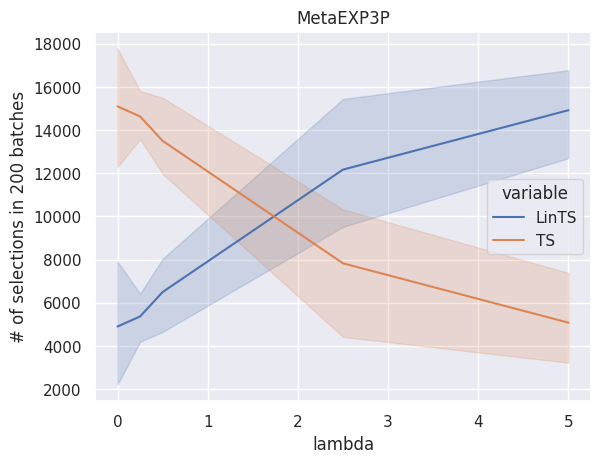

In [8]:
df = pd.DataFrame(results, columns=['lambda', 'LinTS', 'TS'])
df = pd.melt(df, id_vars='lambda')
sns.lineplot(data=df, x='lambda', y='value', hue='variable')
plt.ylabel(f'# of selections in {num_batch} batches')
plt.title('MetaEXP3P')

# MetaCORRAL


In [203]:
np.random.seed(0)
results = []
regrets = []
for lam in lambdas:
    print('lambda:', lam)
    for seed in range(n_random_seed):
        lints = LinTS(dim=dim_context, n_actions=n_actions)
        ts = BernoulliTS(n_actions=n_actions)
        be = BanditEnvironmentSimulator(n_actions=n_actions, dim_context=dim_context, reward_function=logistic_reward_function)
        policy = MetaCORRAL(dim=5, policies=[lints, ts], n_actions=n_actions, T=T)
        regret = []
        for i in tqdm(range(num_batch)):
            # observe contexts
            contexts = be.next_context_batch(n_rounds=n_rounds)
            actions = []
            for context in contexts:
                actions.append(policy.select_action(context))
            # observe rewards
            # adjust impact of contetual effect for reward function
            expected = be.calc_expected_reward(contexts * lam)
            best_actions = pd.DataFrame(expected).idxmax(axis=1)
            regret.append((pd.Series(best_actions) != pd.Series(actions)).tolist())
            rewards = be.sample_reward(contexts * lam)
            policy.update_params(action=np.array(actions), reward=rewards[np.arange(len(rewards)), actions], context=contexts)
        result = [lam]
        for policy_index in range(2):
            result.append((pd.Series(policy.selected_policies) == policy_index).sum())
        print(result, np.array(regret).flatten().sum())
        results.append(result)
        regrets.append(regret)


lambda: 0


100%|██████████| 200/200 [00:03<00:00, 51.27it/s]


[0, 2153, 17847] 1713


100%|██████████| 200/200 [00:04<00:00, 45.54it/s]


[0, 3215, 16785] 2399


100%|██████████| 200/200 [00:04<00:00, 46.09it/s]


[0, 3162, 16838] 2318


100%|██████████| 200/200 [00:03<00:00, 50.87it/s]


[0, 2339, 17661] 2008


100%|██████████| 200/200 [00:03<00:00, 52.04it/s]


[0, 1931, 18069] 1533
lambda: 0.25


100%|██████████| 200/200 [00:04<00:00, 40.44it/s]


[0.25, 4311, 15689] 4149


100%|██████████| 200/200 [00:03<00:00, 50.65it/s]


[0.25, 2228, 17772] 3035


100%|██████████| 200/200 [00:04<00:00, 45.65it/s]


[0.25, 3109, 16891] 3523


100%|██████████| 200/200 [00:05<00:00, 37.22it/s]


[0.25, 5374, 14626] 4656


100%|██████████| 200/200 [00:03<00:00, 57.48it/s]


[0.25, 1221, 18779] 2348
lambda: 0.5


100%|██████████| 200/200 [00:05<00:00, 37.10it/s]


[0.5, 5289, 14711] 7128


100%|██████████| 200/200 [00:06<00:00, 29.21it/s]


[0.5, 8731, 11269] 9403


100%|██████████| 200/200 [00:05<00:00, 38.32it/s]


[0.5, 4793, 15207] 7620


100%|██████████| 200/200 [00:04<00:00, 42.69it/s]


[0.5, 3573, 16427] 6877


100%|██████████| 200/200 [00:05<00:00, 36.53it/s]


[0.5, 5365, 14635] 7580
lambda: 2.5


100%|██████████| 200/200 [00:10<00:00, 19.92it/s]


[2.5, 16345, 3655] 8794


100%|██████████| 200/200 [00:10<00:00, 19.35it/s]


[2.5, 16961, 3039] 8547


100%|██████████| 200/200 [00:09<00:00, 20.17it/s]


[2.5, 15988, 4012] 8883


100%|██████████| 200/200 [00:08<00:00, 23.36it/s]


[2.5, 12644, 7356] 9601


100%|██████████| 200/200 [00:09<00:00, 21.77it/s]


[2.5, 14028, 5972] 9350
lambda: 5


100%|██████████| 200/200 [00:11<00:00, 18.09it/s]


[5, 18891, 1109] 6442


100%|██████████| 200/200 [00:10<00:00, 18.27it/s]


[5, 18726, 1274] 7969


100%|██████████| 200/200 [00:10<00:00, 18.94it/s]


[5, 17900, 2100] 7287


100%|██████████| 200/200 [00:10<00:00, 18.44it/s]


[5, 18687, 1313] 7314


100%|██████████| 200/200 [00:10<00:00, 19.15it/s]

[5, 17532, 2468] 7776


Text(0.5, 1.0, 'MetaCORRAL')

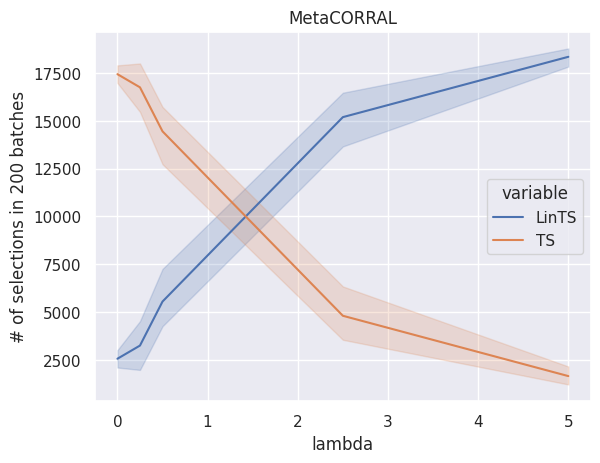

In [204]:
# eta:0.4
df = pd.DataFrame(results, columns=['lambda', 'LinTS', 'TS'])
df = pd.melt(df, id_vars='lambda')
sns.lineplot(data=df, x='lambda', y='value', hue='variable')
plt.ylabel(f'# of selections in {num_batch} batches')
plt.title('MetaCORRAL')

Text(0.5, 1.0, 'MetaCORRAL')

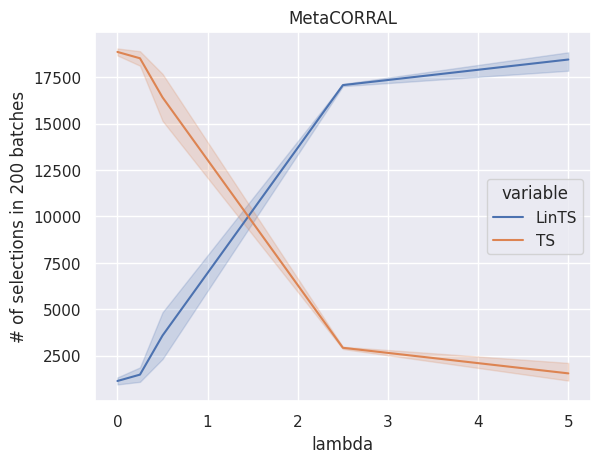

In [151]:
# eta:0.5
df = pd.DataFrame(results, columns=['lambda', 'LinTS', 'TS'])
df = pd.melt(df, id_vars='lambda')
sns.lineplot(data=df, x='lambda', y='value', hue='variable')
plt.ylabel(f'# of selections in {num_batch} batches')
plt.title('MetaCORRAL')

Text(0.5, 1.0, 'MetaCORRAL')

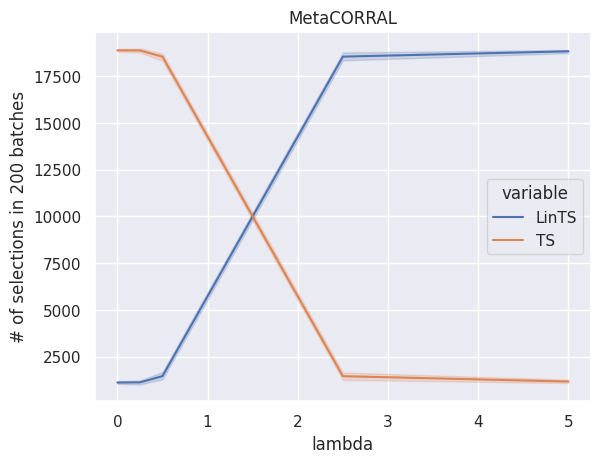

In [15]:
# eta: 0.1
df = pd.DataFrame(results, columns=['lambda', 'LinTS', 'TS'])
df = pd.melt(df, id_vars='lambda')
sns.lineplot(data=df, x='lambda', y='value', hue='variable')
plt.ylabel(f'# of selections in {num_batch} batches')
plt.title('MetaCORRAL')

In [205]:
pd.DataFrame(results).to_csv('../metacorral_eta0.4_selection.csv')
pd.DataFrame(regrets).to_csv('../metacorral_eta0.4_regret.csv')

# MetaEXP3OPE

In [17]:

np.random.seed(0)
results = []
regrets = []
for lam in lambdas:
    print('lambda:', lam)
    for seed in range(n_random_seed):
        lints = LinTS(dim=dim_context, n_actions=n_actions)
        ts = BernoulliTS(n_actions=n_actions)
        be = BanditEnvironmentSimulator(n_actions=n_actions, dim_context=dim_context, reward_function=logistic_reward_function)
        policy = MetaEXPOPE(dim=5, policies=[lints, ts], n_actions=n_actions, T=T)
        regret = []
        for i in tqdm(range(num_batch)):
            # observe contexts
            contexts = be.next_context_batch(n_rounds=n_rounds )
            actions = []
            for context in contexts:
                actions.append(policy.select_action(context))
            # observe rewards
            # adjust impact of contetual effect for reward function
            expected = be.calc_expected_reward(contexts * lam)
            best_actions = pd.DataFrame(expected).idxmax(axis=1)
            regret.append((pd.Series(best_actions) != pd.Series(actions)).tolist())
            rewards = be.sample_reward(contexts * lam)
            policy.update_params(action=np.array(actions), reward=rewards[np.arange(len(rewards)), actions], context=contexts)
        result = [lam]
        for policy_index in range(2):
            result.append((pd.Series(policy.selected_policies) == policy_index).sum())
        print(result, np.array(regret).flatten().sum())
        results.append(result)
        regrets.append(regret)


lambda: 0


100%|██████████| 200/200 [00:13<00:00, 14.32it/s]


[0, 112, 88] 11253


100%|██████████| 200/200 [00:13<00:00, 14.65it/s]


[0, 99, 101] 9912


100%|██████████| 200/200 [00:13<00:00, 14.92it/s]


[0, 96, 104] 9777


100%|██████████| 200/200 [00:13<00:00, 14.62it/s]


[0, 101, 99] 10326


100%|██████████| 200/200 [00:14<00:00, 14.07it/s]


[0, 117, 83] 11557
lambda: 0.25


100%|██████████| 200/200 [00:14<00:00, 13.52it/s]


[0.25, 130, 70] 12293


100%|██████████| 200/200 [00:14<00:00, 13.44it/s]


[0.25, 128, 72] 12564


100%|██████████| 200/200 [00:14<00:00, 13.40it/s]


[0.25, 125, 75] 12762


100%|██████████| 200/200 [00:14<00:00, 13.66it/s]


[0.25, 125, 75] 12550


100%|██████████| 200/200 [00:14<00:00, 13.71it/s]


[0.25, 122, 78] 12141
lambda: 0.5


100%|██████████| 200/200 [00:15<00:00, 13.26it/s]


[0.5, 133, 67] 11997


100%|██████████| 200/200 [00:16<00:00, 12.28it/s]


[0.5, 163, 37] 13781


100%|██████████| 200/200 [00:15<00:00, 12.53it/s]


[0.5, 153, 47] 13377


100%|██████████| 200/200 [00:16<00:00, 12.46it/s]


[0.5, 160, 40] 15399


100%|██████████| 200/200 [00:15<00:00, 13.04it/s]


[0.5, 138, 62] 12798
lambda: 2.5


100%|██████████| 200/200 [00:17<00:00, 11.76it/s]


[2.5, 181, 19] 8790


100%|██████████| 200/200 [00:16<00:00, 11.90it/s]


[2.5, 180, 20] 8012


100%|██████████| 200/200 [00:16<00:00, 11.93it/s]


[2.5, 181, 19] 8170


100%|██████████| 200/200 [00:16<00:00, 12.27it/s]


[2.5, 169, 31] 9508


100%|██████████| 200/200 [00:16<00:00, 12.32it/s]


[2.5, 168, 32] 9655
lambda: 5


100%|██████████| 200/200 [00:15<00:00, 12.56it/s]


[5, 158, 42] 8934


100%|██████████| 200/200 [00:16<00:00, 11.82it/s]


[5, 187, 13] 7069


100%|██████████| 200/200 [00:16<00:00, 12.11it/s]


[5, 176, 24] 7424


100%|██████████| 200/200 [00:16<00:00, 12.32it/s]


[5, 170, 30] 8488


100%|██████████| 200/200 [00:16<00:00, 12.05it/s]

[5, 180, 20] 8168


In [42]:

np.random.seed(0)
results = []
regrets = []
for lam in lambdas:
    print('lambda:', lam)
    for seed in range(n_random_seed):
        lints = LinTS(dim=dim_context, n_actions=n_actions)
        ts = BernoulliTS(n_actions=n_actions)
        be = BanditEnvironmentSimulator(n_actions=n_actions, dim_context=dim_context, reward_function=logistic_reward_function)
        policy = MetaEXPOPE(dim=5, policies=[lints, ts], n_actions=n_actions, T=T)
        regret = []
        for i in tqdm(range(num_batch)):
            # observe contexts
            contexts = be.next_context_batch(n_rounds=n_rounds )
            actions = []
            for context in contexts:
                actions.append(policy.select_action(context))
            # observe rewards
            # adjust impact of contetual effect for reward function
            expected = be.calc_expected_reward(contexts * lam)
            best_actions = pd.DataFrame(expected).idxmax(axis=1)
            regret.append((pd.Series(best_actions) != pd.Series(actions)).tolist())
            rewards = be.sample_reward(contexts * lam)
            policy.update_params(action=np.array(actions), reward=rewards[np.arange(len(rewards)), actions], context=contexts)
        result = [lam]
        for policy_index in range(2):
            result.append((pd.Series(policy.selected_policies) == policy_index).sum())
        print(result, np.array(regret).flatten().sum())
        results.append(result)
        regrets.append(regret)


lambda: 0


100%|██████████| 200/200 [00:15<00:00, 13.18it/s]


[0, 11579, 7438] 11325


100%|██████████| 200/200 [00:15<00:00, 13.26it/s]


[0, 11304, 7718] 11695


100%|██████████| 200/200 [00:15<00:00, 13.28it/s]


[0, 11200, 7794] 11516


100%|██████████| 200/200 [00:15<00:00, 13.26it/s]


[0, 11196, 7843] 11798


100%|██████████| 200/200 [00:15<00:00, 13.14it/s]


[0, 11557, 7432] 11410
lambda: 0.25


100%|██████████| 200/200 [00:15<00:00, 12.56it/s]


[0.25, 13217, 5833] 13428


100%|██████████| 200/200 [00:15<00:00, 12.60it/s]


[0.25, 13126, 5898] 13874


100%|██████████| 200/200 [00:16<00:00, 12.10it/s]


[0.25, 13822, 5143] 12464


100%|██████████| 200/200 [00:16<00:00, 12.26it/s]


[0.25, 13458, 5523] 12617


100%|██████████| 200/200 [00:16<00:00, 12.35it/s]


[0.25, 13301, 5657] 13634
lambda: 0.5


100%|██████████| 200/200 [00:16<00:00, 12.16it/s]


[0.5, 14608, 4355] 15331


100%|██████████| 200/200 [00:16<00:00, 11.82it/s]


[0.5, 15862, 3096] 13091


100%|██████████| 200/200 [00:16<00:00, 11.92it/s]


[0.5, 15591, 3445] 13322


100%|██████████| 200/200 [00:16<00:00, 11.95it/s]


[0.5, 15395, 3576] 14223


100%|██████████| 200/200 [00:16<00:00, 12.11it/s]


[0.5, 14888, 4071] 15890
lambda: 2.5


100%|██████████| 200/200 [00:17<00:00, 11.40it/s]


[2.5, 17325, 1651] 8290


100%|██████████| 200/200 [00:17<00:00, 11.47it/s]


[2.5, 17198, 1788] 7841


100%|██████████| 200/200 [00:17<00:00, 11.46it/s]


[2.5, 17381, 1638] 8026


100%|██████████| 200/200 [00:17<00:00, 11.49it/s]


[2.5, 17208, 1804] 8215


100%|██████████| 200/200 [00:17<00:00, 11.40it/s]


[2.5, 17473, 1498] 7356
lambda: 5


100%|██████████| 200/200 [00:17<00:00, 11.48it/s]


[5, 17014, 1976] 7595


100%|██████████| 200/200 [00:17<00:00, 11.38it/s]


[5, 17055, 1924] 7712


100%|██████████| 200/200 [00:17<00:00, 11.50it/s]


[5, 17139, 1859] 7697


100%|██████████| 200/200 [00:17<00:00, 11.41it/s]


[5, 17188, 1780] 7400


100%|██████████| 200/200 [00:17<00:00, 11.56it/s]

[5, 16921, 2075] 8048


Text(0.5, 1.0, 'MetaEXPOPE')

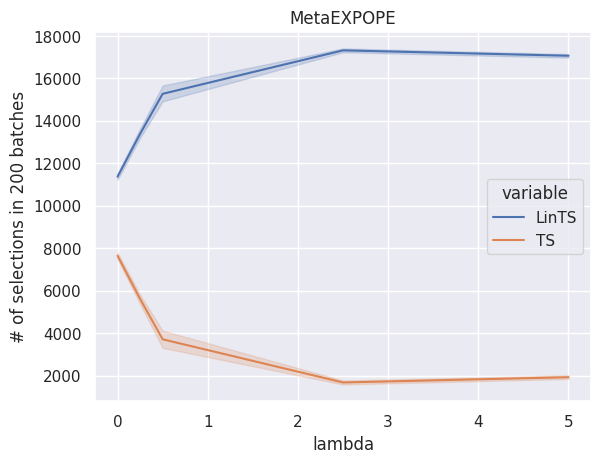

In [43]:
df = pd.DataFrame(results, columns=['lambda', 'LinTS', 'TS'])
df = pd.melt(df, id_vars='lambda')
sns.lineplot(data=df, x='lambda', y='value', hue='variable')
plt.ylabel(f'# of selections in {num_batch} batches')
plt.title('MetaEXPOPE')

In [44]:

pd.DataFrame(results).to_csv('../metaexp3ope_selection.csv')
pd.DataFrame(regrets).to_csv('../metaexp3ope_regret.csv')

# MetaGreedyOPE


In [174]:

np.random.seed(0)
results = []
regrets = []
for lam in lambdas:
    print('lambda:', lam)
    for seed in range(n_random_seed):
        lints = LinTS(dim=dim_context, n_actions=n_actions)
        ts = BernoulliTS(n_actions=n_actions)
        be = BanditEnvironmentSimulator(n_actions=n_actions, dim_context=dim_context, reward_function=logistic_reward_function)
        policy = ModelSelectionPolicy(dim=5, mode='OPE', policies=[lints, ts], n_actions=n_actions, epsilon=0.05)
        regret = []
        for i in tqdm(range(num_batch)):
            # observe contexts
            contexts = be.next_context_batch(n_rounds=n_rounds )
            actions = []
            for context in contexts:
                actions.append(policy.select_action(context))
            # observe rewards
            # adjust impact of contetual effect for reward function
            expected = be.calc_expected_reward(contexts * lam)
            best_actions = pd.DataFrame(expected).idxmax(axis=1)
            regret.append((pd.Series(best_actions) != pd.Series(actions)).tolist())
            rewards = be.sample_reward(contexts * lam)
            policy.update_params(action=np.array(actions), reward=rewards[np.arange(len(rewards)), actions], context=contexts)
        result = [lam]
        for policy_index in range(2):
            result.append((pd.Series(policy.selected_policies) == policy_index).sum())
        print(result, np.array(regret).flatten().sum())
        results.append(result)
        regrets.append(regret)


lambda: 0


100%|██████████| 200/200 [00:10<00:00, 18.87it/s]


[0, 19, 181] 1955


100%|██████████| 200/200 [00:10<00:00, 19.12it/s]


[0, 15, 185] 1562


100%|██████████| 200/200 [00:10<00:00, 18.25it/s]


[0, 27, 173] 2788


100%|██████████| 200/200 [00:10<00:00, 19.44it/s]


[0, 11, 189] 1323


100%|██████████| 200/200 [00:10<00:00, 19.12it/s]


[0, 12, 188] 1271
lambda: 0.25


100%|██████████| 200/200 [00:16<00:00, 11.98it/s]


[0.25, 172, 28] 12182


100%|██████████| 200/200 [00:12<00:00, 15.98it/s]


[0.25, 70, 130] 7463


100%|██████████| 200/200 [00:14<00:00, 13.86it/s]


[0.25, 121, 79] 9075


100%|██████████| 200/200 [00:12<00:00, 15.92it/s]


[0.25, 72, 128] 7445


100%|██████████| 200/200 [00:14<00:00, 13.78it/s]


[0.25, 119, 81] 11858
lambda: 0.5


100%|██████████| 200/200 [00:15<00:00, 12.83it/s]


[0.5, 150, 50] 14151


100%|██████████| 200/200 [00:15<00:00, 12.77it/s]


[0.5, 148, 52] 11584


100%|██████████| 200/200 [00:15<00:00, 12.51it/s]


[0.5, 159, 41] 12699


100%|██████████| 200/200 [00:16<00:00, 12.15it/s]


[0.5, 172, 28] 16112


100%|██████████| 200/200 [00:17<00:00, 11.67it/s]


[0.5, 189, 11] 14091
lambda: 2.5


100%|██████████| 200/200 [00:16<00:00, 11.86it/s]


[2.5, 179, 21] 7537


100%|██████████| 200/200 [00:17<00:00, 11.44it/s]


[2.5, 196, 4] 7340


100%|██████████| 200/200 [00:17<00:00, 11.53it/s]


[2.5, 192, 8] 7699


100%|██████████| 200/200 [00:16<00:00, 12.25it/s]


[2.5, 168, 32] 8289


100%|██████████| 200/200 [00:17<00:00, 11.73it/s]


[2.5, 186, 14] 7384
lambda: 5


100%|██████████| 200/200 [00:16<00:00, 11.79it/s]


[5, 183, 17] 7208


100%|██████████| 200/200 [00:17<00:00, 11.73it/s]


[5, 187, 13] 6801


100%|██████████| 200/200 [00:16<00:00, 11.85it/s]


[5, 180, 20] 7136


100%|██████████| 200/200 [00:17<00:00, 11.62it/s]


[5, 190, 10] 6994


100%|██████████| 200/200 [00:17<00:00, 11.73it/s]

[5, 187, 13] 7151


In [176]:

pd.DataFrame(results).to_csv('../metagreedyope_eps0.05_selection.csv')
pd.DataFrame(regrets).to_csv('../metagreedyope_eps0.05_regret.csv')

# TS

In [22]:
np.random.seed(0)
regrets = []
for lam in lambdas:
    print('lambda:', lam)
    for seed in range(n_random_seed):
        policy = BernoulliTS(n_actions=n_actions)
        regret = []
        for i in tqdm(range(num_batch)):
            # observe contexts
            contexts = be.next_context_batch(n_rounds=n_rounds)
            actions = []
            for context in contexts:
                actions.append(policy.select_action())
            # observe rewards
            # adjust impact of contetual effect for reward function
            expected = be.calc_expected_reward(contexts * lam)
            best_actions = pd.DataFrame(expected).idxmax(axis=1)
            regret.append((pd.Series(best_actions) != pd.Series(actions)).tolist())
            rewards = be.sample_reward(contexts * lam)
            actions = np.array(actions).flatten()
            for a, r in zip(np.array(actions), rewards[np.arange(len(rewards)), np.array(actions)]):
                policy.update_params(action=a, reward=r)
        result = [lam]
        print(np.array(regret).flatten().sum())
        regrets.append(regret)

lambda: 0


100%|██████████| 200/200 [00:00<00:00, 240.74it/s]


271


100%|██████████| 200/200 [00:00<00:00, 243.91it/s]


218


100%|██████████| 200/200 [00:00<00:00, 238.62it/s]


180


100%|██████████| 200/200 [00:00<00:00, 242.94it/s]


268


100%|██████████| 200/200 [00:00<00:00, 239.51it/s]


228
lambda: 0.25


100%|██████████| 200/200 [00:00<00:00, 242.59it/s]


1666


100%|██████████| 200/200 [00:00<00:00, 243.59it/s]


1513


100%|██████████| 200/200 [00:00<00:00, 242.73it/s]


1427


100%|██████████| 200/200 [00:00<00:00, 242.83it/s]


1461


100%|██████████| 200/200 [00:00<00:00, 244.85it/s]


1494
lambda: 0.5


100%|██████████| 200/200 [00:00<00:00, 243.67it/s]


5336


100%|██████████| 200/200 [00:00<00:00, 241.26it/s]


5403


100%|██████████| 200/200 [00:00<00:00, 242.49it/s]


5299


100%|██████████| 200/200 [00:00<00:00, 240.87it/s]


5636


100%|██████████| 200/200 [00:00<00:00, 235.58it/s]


5459
lambda: 2.5


100%|██████████| 200/200 [00:00<00:00, 247.08it/s]


13178


100%|██████████| 200/200 [00:00<00:00, 246.52it/s]


13185


100%|██████████| 200/200 [00:00<00:00, 247.18it/s]


13335


100%|██████████| 200/200 [00:00<00:00, 247.17it/s]


13242


100%|██████████| 200/200 [00:00<00:00, 246.65it/s]


13640
lambda: 5


100%|██████████| 200/200 [00:00<00:00, 247.11it/s]


15421


100%|██████████| 200/200 [00:00<00:00, 245.72it/s]


15355


100%|██████████| 200/200 [00:00<00:00, 246.89it/s]


14810


100%|██████████| 200/200 [00:00<00:00, 242.39it/s]


14573


100%|██████████| 200/200 [00:00<00:00, 237.44it/s]

14941


In [23]:
pd.DataFrame(regrets).to_csv('../ts_regret.csv')

# LinTS

In [49]:
np.random.seed(0)
regrets = []
for lam in lambdas:
    print('lambda:', lam)
    for seed in range(n_random_seed):
        policy = LinTS(dim=dim_context, n_actions=n_actions)
        
        regret = []
        for i in tqdm(range(num_batch)):
            # observe contexts
            contexts = be.next_context_batch(n_rounds=n_rounds)
            actions = []
            for context in contexts:
                actions.append(policy.select_action(context))
            # observe rewards
            # adjust impact of contetual effect for reward function
            expected = be.calc_expected_reward(contexts * lam)
            best_actions = pd.DataFrame(expected).idxmax(axis=1)
            regret.append((pd.Series(best_actions) != pd.Series(actions)).tolist())
            rewards = be.sample_reward(contexts * lam)
            actions = np.array(actions).flatten()
            for a, r, c in zip(np.array(actions), rewards[np.arange(len(rewards)), np.array(actions)], contexts):
                policy.update_params(action=a, reward=r, context=np.array(c[np.newaxis, :]))
        result = [lam]
        print(np.array(regret).flatten().sum())
        regrets.append(regret)


lambda: 0


100%|██████████| 200/200 [00:08<00:00, 22.86it/s]


13033


100%|██████████| 200/200 [00:08<00:00, 22.89it/s]


13246


100%|██████████| 200/200 [00:08<00:00, 22.77it/s]


13447


100%|██████████| 200/200 [00:08<00:00, 22.74it/s]


13144


100%|██████████| 200/200 [00:08<00:00, 22.81it/s]


13069
lambda: 0.25


100%|██████████| 200/200 [00:08<00:00, 22.90it/s]


14290


100%|██████████| 200/200 [00:08<00:00, 22.93it/s]


15446


100%|██████████| 200/200 [00:08<00:00, 23.00it/s]


14295


100%|██████████| 200/200 [00:08<00:00, 22.93it/s]


14002


100%|██████████| 200/200 [00:08<00:00, 22.83it/s]


12745
lambda: 0.5


100%|██████████| 200/200 [00:08<00:00, 22.80it/s]


11862


100%|██████████| 200/200 [00:08<00:00, 22.91it/s]


13293


100%|██████████| 200/200 [00:08<00:00, 22.86it/s]


11849


100%|██████████| 200/200 [00:08<00:00, 22.79it/s]


12078


100%|██████████| 200/200 [00:08<00:00, 22.67it/s]


11259
lambda: 2.5


100%|██████████| 200/200 [00:08<00:00, 22.69it/s]


6758


100%|██████████| 200/200 [00:08<00:00, 22.97it/s]


7703


100%|██████████| 200/200 [00:08<00:00, 22.79it/s]


7640


100%|██████████| 200/200 [00:08<00:00, 22.64it/s]


6947


100%|██████████| 200/200 [00:08<00:00, 22.64it/s]


8019
lambda: 5


100%|██████████| 200/200 [00:08<00:00, 22.67it/s]


6125


100%|██████████| 200/200 [00:08<00:00, 22.66it/s]


6565


100%|██████████| 200/200 [00:08<00:00, 22.87it/s]


7313


100%|██████████| 200/200 [00:08<00:00, 22.97it/s]


7105


100%|██████████| 200/200 [00:08<00:00, 22.96it/s]

5891


In [50]:
pd.DataFrame(regrets).to_csv('../lints_regret.csv')

# Visualization

Text(0.5, 1.0, 'MetaGreedyOPE')

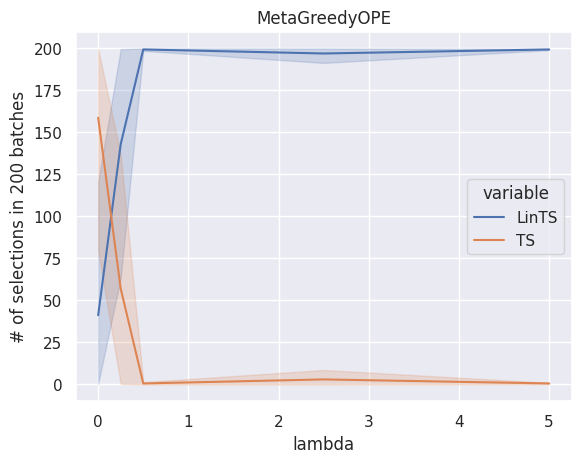

In [249]:
df = pd.read_csv('../metagreedyope_selection.csv', index_col=0)
df.columns = ['lambda', 'LinTS', 'TS']
df = pd.melt(df, id_vars='lambda')
sns.lineplot(data=df, x='lambda', y='value', hue='variable')

plt.ylabel(f'# of selections in {num_batch} batches')
plt.title('MetaGreedyOPE')

# Regret

In [108]:
def visualize_regret(fname):
    df = pd.read_csv(f'../{fname}_regret.csv', index_col=0)
    lis = []
    for i in range(df.shape[0]):
        li = []
        for j in range(df.shape[1]):
            li += eval(df.iloc[i, j])
        lis.append(li)
    regrets = pd.DataFrame(lis, index=np.repeat(lambdas, repeats=5)).cumsum(axis=1)
    regrets['lambda'] = regrets.index
    
    regrets_melt = pd.melt(regrets.iloc[:, ::100], id_vars='lambda')
    sns.lineplot(data=regrets_melt, x='variable', y='value', hue='lambda', palette='deep')
    plt.ylabel(f'regret')
    plt.xlabel(f'steps')
    plt.title(f'{fname}')

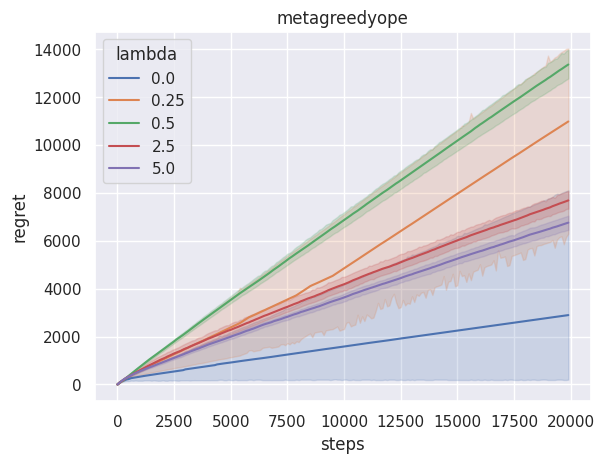

In [109]:
visualize_regret('metagreedyope')

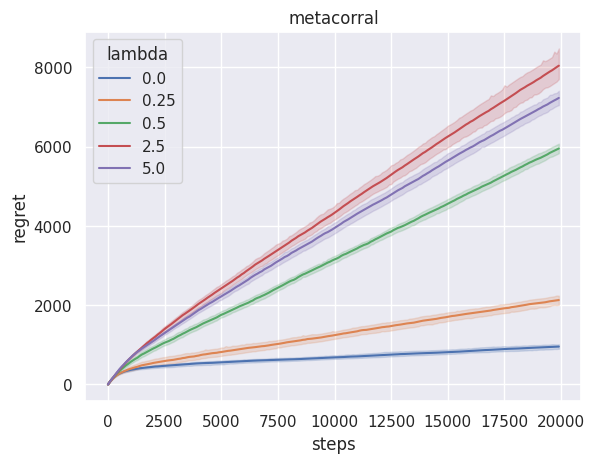

In [110]:
visualize_regret('metacorral')

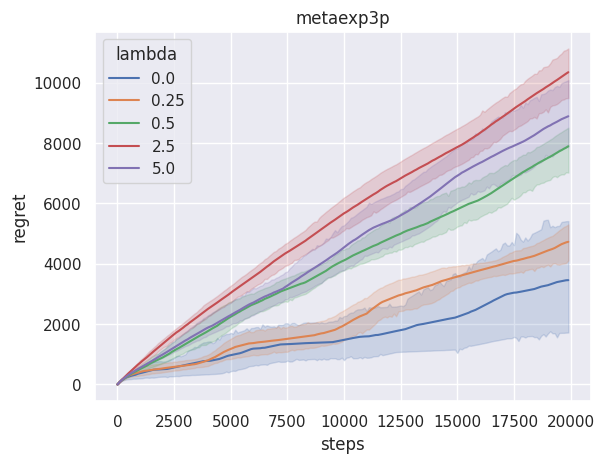

In [111]:
visualize_regret('metaexp3p')

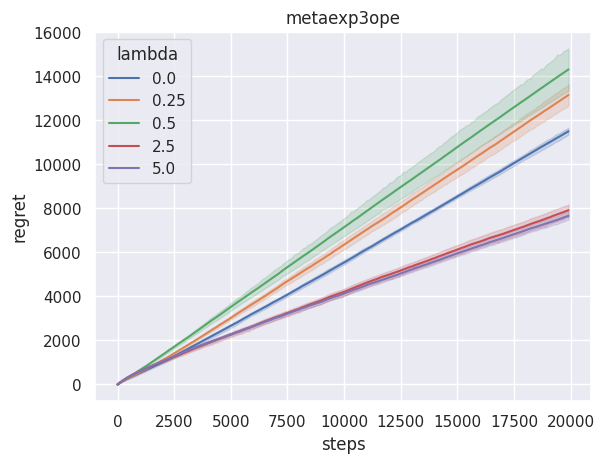

In [112]:
visualize_regret('metaexp3ope')

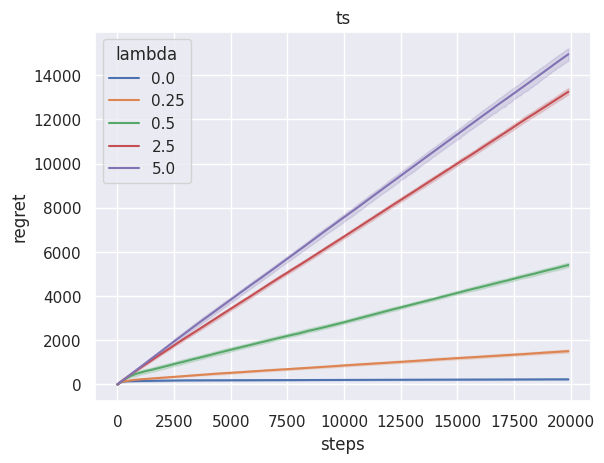

In [113]:
visualize_regret('ts')

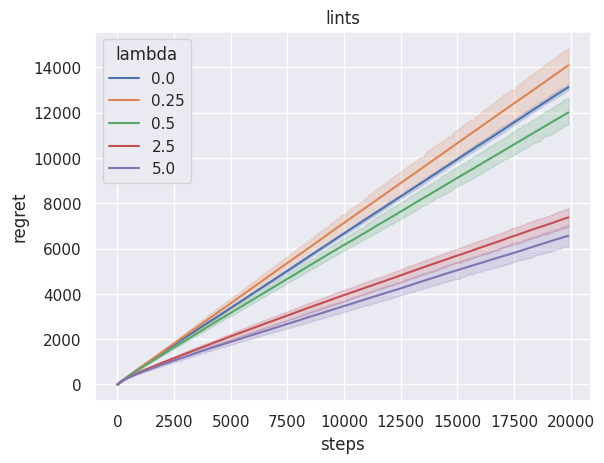

In [114]:
visualize_regret('lints')

## Regret_comparison

In [346]:
models = ['metaexp3ope', 'metaexp3p', 'metagreedyope_eps0.05', 'metacorral_eta0.4', 'lints', 'ts']

In [ ]:
al = pd.DataFrame()
for model in models:
    df = pd.read_csv(f'../{model}_regret.csv', index_col=0)
    lis = []
    for i in range(df.shape[0]):
        li = []
        for j in range(df.shape[1]):
            li += eval(df.iloc[i, j])
        lis.append(li)
    regrets = pd.DataFrame(lis, index=np.repeat(lambdas, repeats=5)).cumsum(axis=1)
    regrets['lambda'] = regrets.index
    al[model] = regrets.iloc[:, -2]


In [357]:
al['lambda'] = al.index

al = pd.melt(al, id_vars='lambda')

In [358]:
legend_replace ={'metaexp3ope': 'MetaEXPOPE (ours)',
                 'metaexp3p': 'MetaEXP3P',
                 'metagreedyope_eps0.05': 'MetaGreedyOPE (ours)',
                 'metacorral_eta0.4': 'MetaCORRAL',
                 'lints': 'LinTS',
                 'ts': 'TS'}
al['variable'] = al['variable'].replace(legend_replace)

In [ ]:
plt.figure(figsize=(6, 5), facecolor="w")

sns.lineplot(data=al, x='lambda', y='value', hue='variable', marker='o')
plt.ylabel('Cumulative regret')
plt.xlabel('λ (influence of contextual features)')
plt.legend( loc='lower right', fontsize=11)

# Adoptation_ratio

In [333]:
models = ['metaexp3ope', 'metaexp3p', 'metagreedyope_eps0.05', 'metacorral_eta0.4']

In [334]:
al = pd.DataFrame()
for model in models:
    df = pd.read_csv(f'../{model}_selection.csv', index_col=0)
    df.columns = ['lambda', 'LinTS', 'TS']
    al[model] = df['LinTS']/(df['LinTS'] + df['TS'])

In [335]:
al['lambda'] = np.repeat(lambdas, repeats=5)

al = pd.melt(al, id_vars='lambda')

In [336]:
legend_replace ={'metaexp3ope': 'MetaEXPOPE (ours)',
                 'metaexp3p': 'MetaEXP3P',
                 'metagreedyope_eps0.05': 'MetaGreedyOPE (ours)',
                 'metacorral_eta0.4': 'MetaCORRAL',
                 'lints': 'LinTS',
                 'ts': 'TS'}
al['variable'] = al['variable'].replace(legend_replace)

Text(0.5, 0, 'λ (influence of contextual features)')

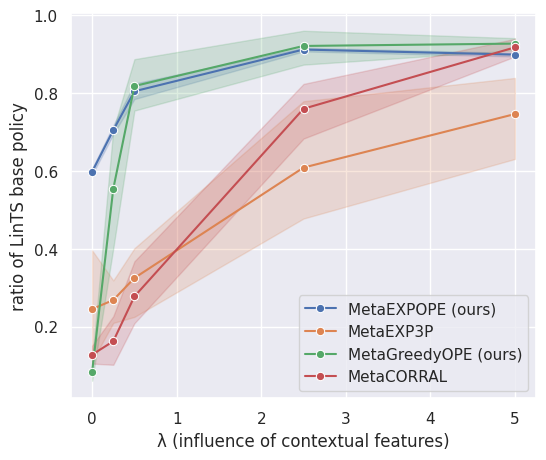

In [337]:
plt.figure(figsize=(6, 5), facecolor="w")
sns.lineplot(data=al, x='lambda', y='value', hue='variable', marker='o')
plt.legend( fontsize=11)
plt.ylabel(f'ratio of LinTS base policy')
plt.xlabel('λ (influence of contextual features)')
